<a href="https://colab.research.google.com/github/Elotmanix/Physics-informed-NN/blob/main/HeatEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import deepxde as dde

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x)
    return (dy_t - dy_xx * 0.3)

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics=["mse"])

losshistory, train_state = model.train(epochs=10000)

x_data = np.linspace(-1, 1, num=100)
t_data = np.linspace(0, 1, num=100)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T

predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

Compiling model...
Building feed-forward neural network...
'build' took 0.118617 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.929989 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.17e-02, 1.57e-01, 2.80e-01]    [1.31e-02, 1.57e-01, 2.80e-01]    [1.73e-01]    
1000      [2.09e-04, 3.50e-05, 8.15e-05]    [2.72e-04, 3.50e-05, 8.15e-05]    [1.42e-02]    
2000      [9.79e-05, 1.37e-05, 1.47e-05]    [1.20e-04, 1.37e-05, 1.47e-05]    [1.42e-02]    
3000      [3.24e-04, 1.37e-04, 1.39e-04]    [3.14e-04, 1.37e-04, 1.39e-04]    [1.41e-02]    
4000      [4.78e-04, 6.60e-05, 5.74e-05]    [2.86e-04, 6.60e-05, 5.74e-05]    [1.35e-02]    
5000      [2.39e-04, 1.90e-05, 3.29e-05]    [2.20e-04, 1.90e-05, 3.29e-05]    [1.39e-02]    
6000      [5.62e-05, 3.27e-06, 4.65e-06]    [6.30e-05, 3.27e-06, 4.65e-06]    [1.41e-02]    
7000      [1.64e-03, 3.66e-05, 1.89e-04]    [9.64e-04, 3.66e-05, 1.89e-04]    [1.44e-02]    
8000      [2.10e-03, 4.08e-04, 3.94e-04]    [1.57e-03, 4.08e-04, 3.94e-04]    [1.46e-02]    
9000      [1.18e-04, 1.2

In [ ]:
# Evaluate the exact solution at the test points
exact_solution = func(test_domain)

# Calculate the mean squared error
mse = np.mean((predicted_solution - exact_solution) ** 2)
print(f"Mean Squared Error (MSE): {mse:.6f}")

Mean Squared Error (MSE): 0.052119


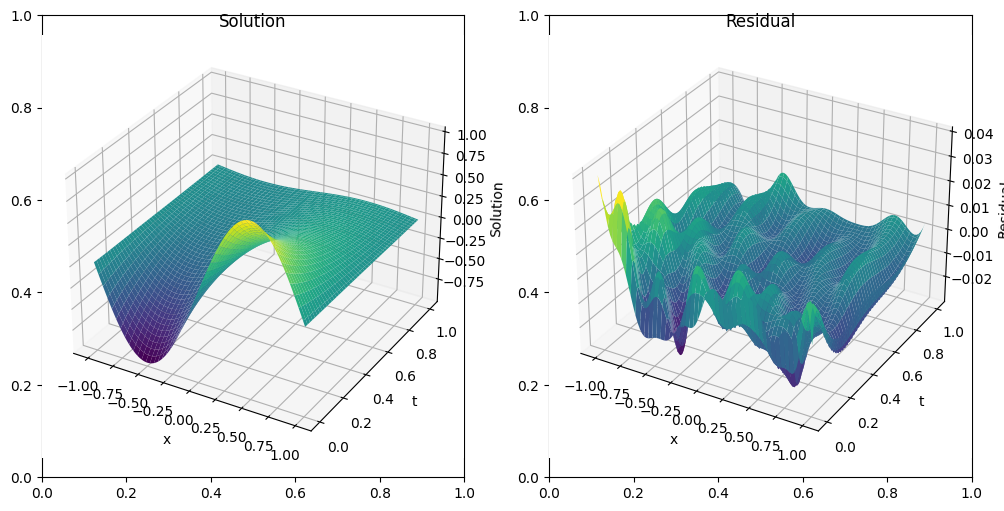

In [ ]:
# prompt: PLOT in 3D the solution and the residual in separatly

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the solution
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(test_x, test_t, predicted_solution, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Solution')
ax1.set_title('Solution')

# Plot the residual
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(test_x, test_t, residual, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Residual')
ax2.set_title('Residual')

plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.095241 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.034041 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [9.77e-03, 5.10e-03, 4.55e-01, 2.43e-03]    [1.21e-02, 5.10e-03, 4.55e-01, 2.43e-03]    [1.60e-01]    
1000      [2.05e-03, 1.29e-02, 9.85e-02, 1.16e-02]    [2.14e-03, 1.29e-02, 9.85e-02, 1.16e-02]    [1.75e-01]    
2000      [5.18e-04, 1.22e-04, 1.07e-03, 7.78e-04]    [8.79e-04, 1.22e-04, 1.07e-03, 7.78e-04]    [2.74e-01]    
3000      [4.68e-03, 3.26e-04, 4.45e-04, 1.27e-03]    [6.57e-03, 3.26e-04, 4.45e-04, 1.27e-03]    [2.62e-01]    
4000      [1.68e-03, 2.16e-04, 5.10e-04, 2.28e-03]    [2.34e-03, 2.16e-04, 5.10e-04, 2.28e-03]    [2.56e-01]    
5000      [1.32e-04, 5.83e-05, 3.03e-04, 1.91e-04]    [1.81e-04, 5.83e-05, 3.03e-04, 1.91e-04]    [2.55e-01]    
6000      [2.12e-03, 1.03e-04, 4.72e-04, 1.45e-04]    [2.30e-03, 1.03e-04, 4.72e-04, 1.45e-04]    [2.51e-01]    
7000      [3.94e-03, 1.03e-03, 2.09e-03, 1.01e-02]

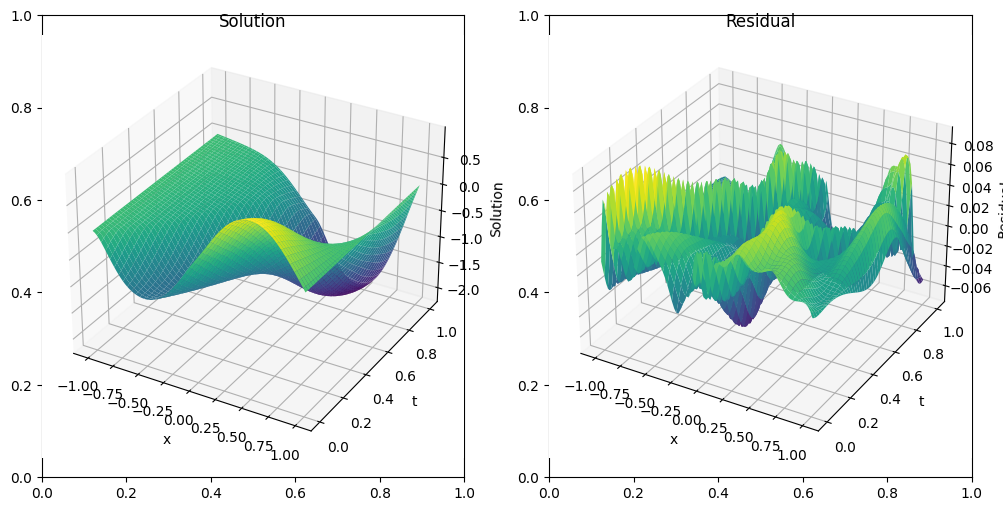

In [ ]:
import numpy as np
import deepxde as dde

# Define geometry and time domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the PDE (wave equation with c = 1)
def pde(x, y):
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_tt - dy_xx

# Initial condition u(x, 0) = sin(pi * x)
def func_u0(x):
    return np.sin(np.pi * x[:, 0:1])

# Initial condition u_t(x, 0) = 0
def func_ut0(x):
    return np.zeros_like(x[:, 0:1])

# Boundary condition u(-1, t) = u(1, t) = 0
def boundary_func(x, on_boundary):
    return on_boundary and (np.isclose(x[0], -1) or np.isclose(x[0], 1))

# Create Dirichlet boundary condition
bc = dde.DirichletBC(geomtime, lambda x: 0, boundary_func)

# Create initial conditions
ic_u = dde.IC(geomtime, func_u0, lambda _, on_initial: on_initial)
ic_ut = dde.OperatorBC(
    geomtime, lambda x, y, _: dde.grad.jacobian(y, x, j=1), lambda _, on_initial: on_initial
)

# Define the data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_u, ic_ut],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func_u0,  # This is just for test purposes
    num_test=1000,
)

# Define the neural network
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

# Create the model
model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics=["mse"])

# Train the model
losshistory, train_state = model.train(epochs=10000)

# Create test data
x_data = np.linspace(-1, 1, num=100)
t_data = np.linspace(0, 1, num=100)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T

# Predict the solution
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

# Evaluate the exact solution at the test points
exact_solution = func_u0(test_domain)

# Calculate the mean squared error
mse = np.mean((predicted_solution - exact_solution) ** 2)
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Plot the solution and residual
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the solution
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(test_x, test_t, predicted_solution.reshape(test_x.shape), cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Solution')
ax1.set_title('Solution')

# Plot the residual
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(test_x, test_t, residual.reshape(test_x.shape), cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Residual')
ax2.set_title('Residual')

plt.show()

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the geometry and time domain
geom = dde.geometry.Rectangle([0, 0], [1, 1]) # Use Rectangle to define a unit square
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the Poisson equation
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx

# Define the boundary conditions
# Use a lambda function to define the boundary condition
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary)

# Define the initial condition
def initial_condition(x):
    return np.zeros_like(x[:, 0:1])


# Pass the DirichletBC object 'bc' to the TimePDE constructor
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, initial_condition], # Pass the DirichletBC object here
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
)

# Define the neural network
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

# Create the model
model = dde.Model(data, net)
model.compile("adam", lr=0.01, metrics=["mse"])

# Train the model
losshistory, train_state = model.train(epochs=10000)

# Create test data
x_data = np.linspace(0, 1, num=100)
t_data = np.linspace(0, 1, num=100)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T

# Predict the solution
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

# Calculate the mean squared error
mse = np.mean((predicted_solution - initial_condition(test_domain)) ** 2)
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Plot the solution and residual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the solution
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(test_x, test_t, predicted_solution.reshape(test_x.shape), cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Solution')
ax1.set_title('Solution')

# Plot the residual
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(test_x, test_t, residual.reshape(test_x.shape), cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Residual')
ax2.set_title('Residual')

plt.show()

Epoch [1000/10000], Loss: nan
Epoch [2000/10000], Loss: nan
Epoch [3000/10000], Loss: nan
Epoch [4000/10000], Loss: nan
Epoch [5000/10000], Loss: nan
Epoch [6000/10000], Loss: nan
Epoch [7000/10000], Loss: nan
Epoch [8000/10000], Loss: nan
Epoch [9000/10000], Loss: nan
Epoch [10000/10000], Loss: nan
Mean Squared Error (MSE): 21.220552


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


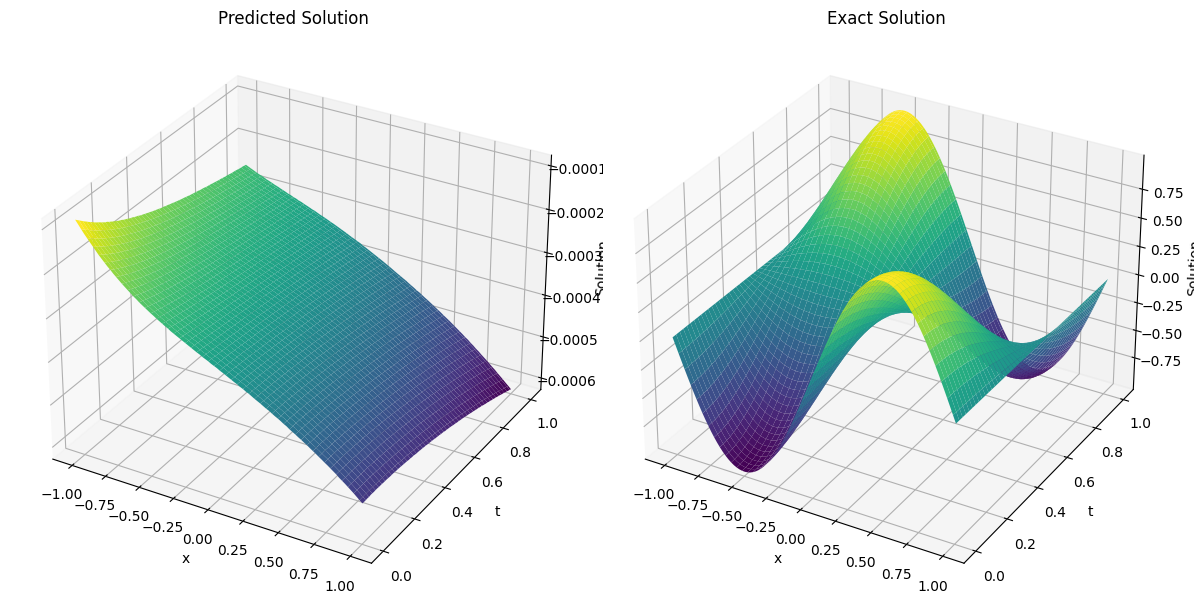

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
torch.manual_seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2, 32)
        self.hidden_layer2 = nn.Linear(32, 32)
        self.hidden_layer3 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.tanh(self.hidden_layer1(x))
        x = torch.tanh(self.hidden_layer2(x))
        x = torch.tanh(self.hidden_layer3(x))
        x = self.output_layer(x)
        return x

# Initialize the network
net = Net().to(device)

# Loss function
def loss_function(x, t):
    x.requires_grad = True
    t.requires_grad = True

    input_xt = torch.cat([x, t], dim=1)
    u = net(input_xt)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]

    pde_loss = torch.mean((u_tt - u_xx)**2)

    # Initial condition u(x, 0) = sin(pi * x)
    ic_u = torch.sin(np.pi * x[t.squeeze() == 0])
    ic_u_pred = u[t.squeeze() == 0]
    ic_u_loss = torch.mean((ic_u - ic_u_pred)**2)

    # Initial condition u_t(x, 0) = 0
    ic_ut_pred = u_t[t.squeeze() == 0]
    ic_ut_loss = torch.mean(ic_ut_pred**2)

    # Boundary condition u(-1, t) = u(1, t) = 0
    bc_pred = u[(x.squeeze() == -1) | (x.squeeze() == 1)]
    bc_loss = torch.mean(bc_pred**2)

    total_loss = pde_loss + ic_u_loss + ic_ut_loss + bc_loss

    return total_loss

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# Training
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate random points in the domain
    x = torch.rand(4000, 1, device=device) * 2 - 1  # -1 to 1
    t = torch.rand(4000, 1, device=device)  # 0 to 1

    loss = loss_function(x, t)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
net.eval()
with torch.no_grad():
    x_data = torch.linspace(-1, 1, 100, device=device).unsqueeze(1)
    t_data = torch.linspace(0, 1, 100, device=device).unsqueeze(1)
    x_mesh, t_mesh = torch.meshgrid(x_data.squeeze(), t_data.squeeze())
    xt_mesh = torch.stack((x_mesh, t_mesh), dim=-1).view(-1, 2)

    predicted_solution = net(xt_mesh).cpu().numpy().reshape(100, 100)

    # Calculate exact solution
    exact_solution = torch.sin(np.pi * x_mesh) * torch.cos(np.pi * t_mesh)
    exact_solution = exact_solution.cpu().numpy()

    # Calculate MSE
    mse = np.mean((predicted_solution - exact_solution)**2)
    print(f"Mean Squared Error (MSE): {mse:.6f}")

# Plotting
fig = plt.figure(figsize=(12, 6))

# Plot the predicted solution
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x_mesh.cpu(), t_mesh.cpu(), predicted_solution, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('Solution')
ax1.set_title('Predicted Solution')

# Plot the exact solution
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x_mesh.cpu(), t_mesh.cpu(), exact_solution, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_zlabel('Solution')
ax2.set_title('Exact Solution')

plt.tight_layout()
plt.show()